# Hyperlocal Air Quality Prediction

### Introduction

The [Environmental Defense Fund (EDF)](https://www.edf.org/airqualitymaps) has partnered with Google Earth Outreach to map air pollution at the **hyperlocal level**. In various cities around the world, mobile air quality sensors were used to gather air pollution data at street level. This new approach allows researchers to collect much more data at a granular level and showed how air poluution varied over very short distances. 

Our project focuses on the data collected in [Houston](https://www.edf.org/airqualitymaps/houston), where low cost mobile sensors were outfitted on city fleet vehicles and Google Street View cars, in addition to gathering data from stationary sensors. For this report, we have focused on only one type of pollution - NO2 emissions.

Based on our review of literature and exploring various datasets, we have decided the scope of our project to explore the use of machine learning models to predict air quality at any location in Houston based on meteorlogical conditions, sources of emissions from various facilities, and traffic.

### Inspiration

Our project is inspired and informed by Varsha Gopalakrishnan's "Hyperlocal Air Quality Prediction using Machine Learning" project, outlined on [Medium](https://towardsdatascience.com/hyperlocal-air-quality-prediction-using-machine-learning-ed3a661b9a71). Gopalakrishnan performed her analysis using Oakland data, and we intend to replicate most aspects of the approach for Houston.

### Data

The level of pollution at any place depends on a number of factors like traffic on major streets; emissions from different facilities like railroads, ports, and industries; and meteorological factors like temperature and precipitation. Our target variable is Air Quality Data obtained from the aforementioned pilot done by EDF. We conducted exploratory data analysis for the air quality dataset in our [Houston air quality data Jupyter Notebook](https://github.com/vjoseph21/air-quality-prediction/blob/main/notebooks/cleaning/air_quality.ipynb).

We classified our potential features into the following three buckets:

#### 1. Traffic Data - [Link to notebook](https://github.com/vjoseph21/air-quality-prediction/blob/main/notebooks/cleaning/traffic_data.ipynb)
We look at the geographical range for which EDF collected the air quality data in Houston. The coordinates for the area around Houston is based on minimum and maximum of latitude and longitude from the EDF data. We chose this area as the bounding box to determine location of all traffic signals / intersections within that boundary.

The Overpass API from Open Street Maps is used to determine the location of all traffic signals (intersections) within a given bounding box. The Overpy library is used to send the request to the API and this call returns the latitude and longitude of all traffic signals. Next, the distance between each traffic intersection and each point in the monitoring data is measured. A traffic score is calculated as the 'Number of traffic intersections within 1,000 ft of each point in the monitoring data."

Going forward, in addition to intersections, we will also extend the analysis to look at the distance of bus stops and highways from the NO2 monitoring points.

#### 2. Emissions Data - [Link to notebook](https://github.com/vjoseph21/air-quality-prediction/blob/main/notebooks/cleaning/facility_data.ipynb)


#### 3. Meteorological factors - [Link to notebook](https://github.com/vjoseph21/air-quality-prediction/blob/main/notebooks/cleaning/met_data.ipynb)
Following Gopalakrishnan's approach, we use the [Daymet](https://daymet.ornl.gov/web_services) API to collect our meteorological data. Daymet's "daily surface weather and climatological summaries" provide daily data at a 1km grid granularity, extrapolated from less-granular meteorological observations. Through approximately 200 calls to the Daymet API, we gathered the available daily data (maximum temperature, minimum temperature, shortwave radiation, vapor pressure, and precipitation) at latitudes and longitudes corresponding to the locations of our air quality measurements, and produced averages for each metric across the 9 months when EDF was collecting air quality data in Houston.

Going forward, we plan to explore alternate approaches to collapsing the daily data for each air quality measurement site - for example, it's possible that minimums or maximums over the 9-month period in question would be more meaningful than averages.

### Modeling 
We will use this dataset to develop a model to predict air quality in neighbourhoods in Houston where the EDF project did not collect air quality data. We plan to first train the machine learning model to predict NO2 emissions on the same locations as the EDF data and then use the trained model and additional traffic, features, and emissions data to preduct concentrations elsewhere in Houston.

For the baseline model, we have merged all the features mentioned above into one dataset and used linear regression for feature selection. We decided to use a threshold of $\pm90$% to indicate very high correlation between features and dropped them to avoid multicollineairty. We then use the remaining features to run a simple linear regression to guage the siginificance of each feature on NO2 emissions. Our results indicate that minimum temperature, precipitation, and number of intersections are the most important features to predict air quality.

In [3]:
#Import basic python packages for data analysis and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.lines as mlines
import pylab as plot
import matplotlib
import random
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
import time

### Import Scipy stats packages
from scipy.stats import pearsonr
from scipy.stats import boxcox


# Import statsmodel packages
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

# import sklearn packages
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import ElasticNet

import re
import os


import warnings
warnings.filterwarnings("ignore")

sns.set(style = 'whitegrid')
sns.set_palette('bright')
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Dataset prep

In [4]:
# merge all datasets to create master_df

root = os.path.dirname(os.path.dirname(os.getcwd()))

df_aq = pd.read_csv(root + "/data/cleaned/air_quality_NO2.csv", index_col=0)[['value','latitude', 'longitude']]
df_met = pd.read_csv(root + "/data/cleaned/nO2_met.csv", index_col=0)
df_fac = pd.read_csv(root + "/data/cleaned/no2_fac_data.csv", index_col=0)
df_traffic = pd.read_csv(root + "/data/cleaned/intersection_final.csv", index_col=0)

df_m1 = df_aq.merge(df_met, on = ['latitude', 'longitude'], how = 'inner')
df_m2 = df_m1.merge(df_fac, on = ['latitude', 'longitude'], how = 'inner')
df_merged = df_m2.merge(df_traffic, on = ['latitude', 'longitude'], how = 'inner')
df_merged.drop(columns = ['latitude', 'longitude'], inplace=True)

## Feature selection

In [5]:
# create feature list and scale
feature_df = df_merged.drop(columns = ['value'])

#Standardizing features
feature_df_scaled = pd.DataFrame(StandardScaler().fit_transform(feature_df), index = feature_df.index, columns = feature_df.columns)

df_merged_scaled = pd.concat([df_merged['value'], feature_df_scaled], axis = 1)

In [9]:
# ols fit on individual features

r2 = []
for column in feature_df.columns[0:]:
    r2_val = sm.OLS(df_merged['value'], feature_df[column]).fit().rsquared
    r2.append(r2_val)
r2_score_df = pd.DataFrame({'Feature': feature_df.columns, 'Individual_R2':r2})


r2_score_df.sort_values('Individual_R2', ascending = False)

,Feature,Individual_R2
0,prcp,0.756036
33,11765311-Airport-low_dist,0.749319
73,12026411-Airport-low_dist,0.749319
101,12254111-Airport-low_dist,0.749319
109,12257011-Airport-low_dist,0.749319
7,10999611-Airport-low_dist,0.749319
57,11892511-Airport-low_dist,0.749319
31,11746411-Airport-low_dist,0.749319
97,12253511-Airport-low_dist,0.749319
93,12208711-Airport-low_dist,0.749319


### Lasso Regression for Feature Selection

In [5]:
# identifying all the features that have a correlation higher than 0.90 or lower than -0.90 indicating a strong positive or negative correlation

threshold_1 = 0.90
threshold_2 = -0.90

def features_high_corr(df_features_corr):
    columns = np.full((df_features_corr.shape[0],), True, dtype=bool)
    for i in range(df_features_corr.shape[0]):
        for j in range(i+1, df_features_corr.shape[0]):
            if (df_features_corr.iloc[i,j] >= threshold_1) | (df_features_corr.iloc[i,j] <= threshold_2) :
                if columns[j]:
                    columns[j] = False
    selected_columns = df_features_corr.columns[columns]
    return selected_columns

In [6]:
# list of features that are not highly correlated
features_corr = feature_df.corr()
features_OLS = features_high_corr(features_corr)
print("Features in BC dataset that are not highly correlated: ")
print(features_OLS)

Features in BC dataset that are not highly correlated: 
Index(['prcp', 'tmin', 'number_intersections'], dtype='object')


In [7]:
#Create a dataframe with air quality value and selected columns from above
OLS_df = df_merged[['value']].join(df_merged[list(features_OLS)])

module://matplotlib_inline.backend_inline


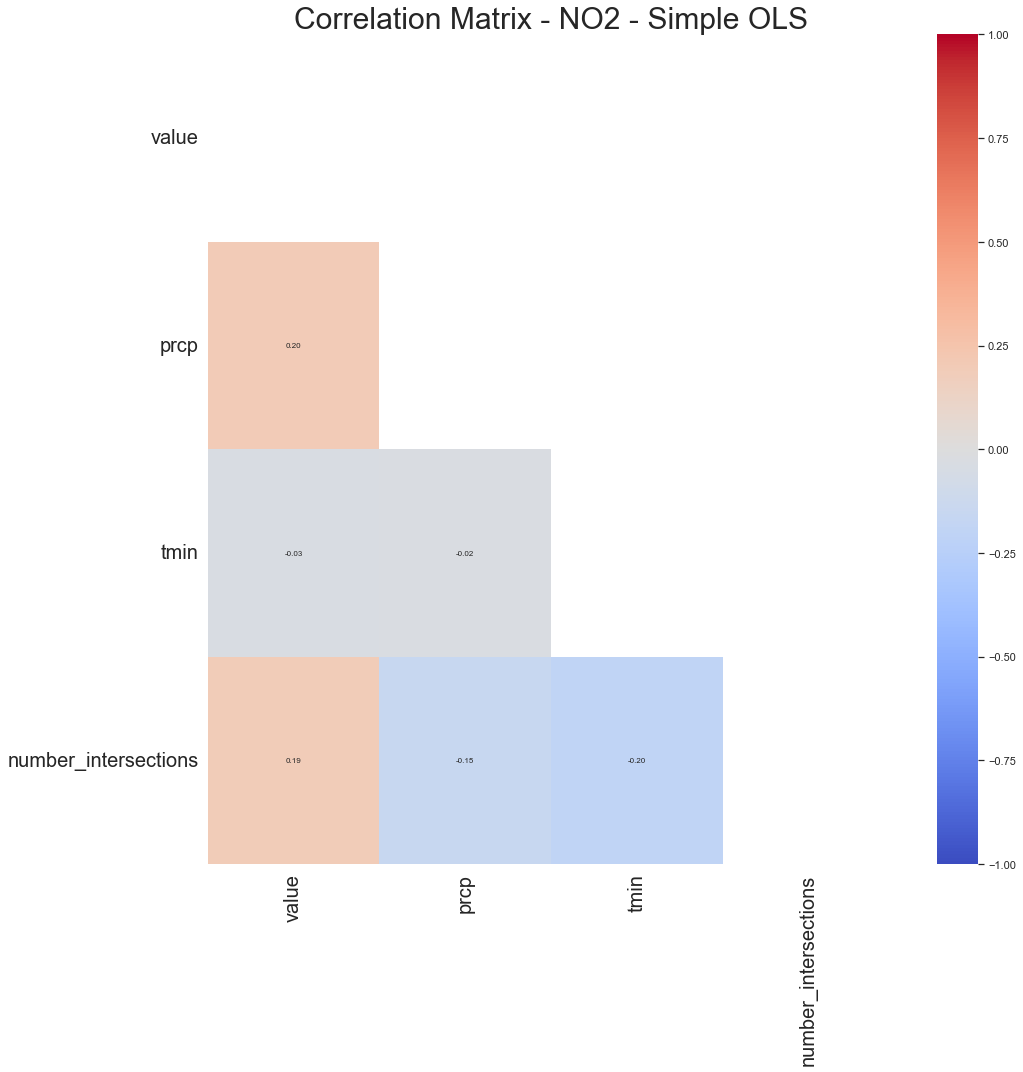

In [8]:
## Plot Correlation matrix
OLS_df_corr = OLS_df.corr()
features_corr_mat = OLS_df_corr.values

print(plt.get_backend())

# close any existing plots
plt.close("all")

# mask out the top triangle
features_corr_mat[np.triu_indices_from(features_corr_mat)] = np.nan

fig, ax = plt.subplots(figsize=(15, 15))

hm = sns.heatmap(features_corr_mat, cbar=True, vmin = -1, vmax = 1, center = 0,
                 fmt='.2f', annot_kws={'size': 8}, annot=True, 
                 square=False, cmap = 'coolwarm')

ticks = np.arange(OLS_df_corr.shape[0]) + 0.5
ax.set_xticks(ticks)
ax.set_xticklabels(OLS_df_corr.columns, rotation=90, fontsize=20)
ax.set_yticks(ticks)
ax.set_yticklabels(OLS_df_corr.index, rotation=360, fontsize=20)

ax.set_title('Correlation Matrix - NO2 - Simple OLS', fontsize  = 30)
plt.tight_layout()

### Fitting an OLS Model on the Shortlisted Features

In [9]:
# OLS
OLS_corr_model = sm.OLS(df_merged['value'], feature_df[features_OLS])
OLS_corr_results = OLS_corr_model.fit() 
OLS_corr_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  value   R-squared (uncentered):                   0.771
Model:                            OLS   Adj. R-squared (uncentered):              0.771
Method:                 Least Squares   F-statistic:                          1.272e+04
Date:                Sun, 15 May 2022   Prob (F-statistic):                        0.00
Time:                        19:01:21   Log-Likelihood:                          68164.
No. Observations:               11314   AIC:                                 -1.363e+05
Df Residuals:                   11311   BIC:                                 -1.363e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
prcp                     0.0004   1.75e-05     25.327      0.000       0.000       0.000
tmin                    -0.0001   7.13e-06    -17.016      0.000      -0.000      -0.000
number_intersections  5.117e-05    2.1e-06     24.419      0.000    4.71e-05    5.53e-05
==============================================================================
Omnibus:                     6954.387   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            75242.644
Skew:                           2.843   Prob(JB):                         0.00
Kurtosis:                      14.282   Cond. No.                         58.1
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
# R2, Coefficient and Intercept
print("The R2 is {}".format(OLS_corr_results.rsquared), "The R2 tells us that there is a correlation between the features identified and NO2 concentration. ")

The R2 is 0.7713786069962676 The R2 tells us that there is a correlation between the features identified and NO2 concentration. 


### Takeaways

From our baseline model, we observe statistically significant but small associations between NO2 levels and a location's average precipitation, average minimum temperature, and number of nearby intersections. Going forward we'll be exploring other ways to wrangle our third source of data - emissions - to be able to include it in our model without running into issues of multicollinearity. Additionally, we'll be adding further traffic data (highways, bus stops) and exploring alternative ways to manipulate the meterological data (minimums instead of 9-month averages, etc.). And we'll be moving beyond OLS to explore machine learning approaches and, finally, predict air quality levels in other Houston neighborhoods.